In [1]:
import network
import torch
from PIL import Image
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import cv2
import utils
from datasets.acdc import ACDCDataset
import os
from torch.utils.data import DataLoader, Dataset
from utils.ext_transforms import *
from utils.utils import Denormalize, denormalize
from pathlib import Path

MODEL_NAME = 'deeplabv3plus_resnet101'
NUM_CLASSES = 19
OUTPUT_STRIDE = 16
TARGET_RESOLUTION = (768, 768)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

denorm = Denormalize(MEAN, STD)

In [44]:
model = network.modeling.__dict__[MODEL_NAME](num_classes=NUM_CLASSES, output_stride=OUTPUT_STRIDE)
model.load_state_dict(torch.load('/media/talmacsi/48a93eb4-f27d-48ec-9f74-64e475c3b6ff/Downloads/best_deeplabv3plus_resnet101_cityscapes_os16.pth.tar')['model_state'])

model.to('cuda')
model = model.eval()

decode_fn = ACDCDataset.decode_target
utils.set_bn_momentum(model.backbone, momentum=0.01)

In [2]:
data_root = Path('/media/talmacsi/48a93eb4-f27d-48ec-9f74-64e475c3b6ff/Downloads/data')
rgb_anon_path = data_root / 'rgb_anon'
gt_path = data_root / 'gt'

In [15]:
transform = ExtCompose([
    ExtRandomHorizontalFlip(p=0.5),
    ExtResize(size=(1080//4,1920//4), interpolation=Image.BILINEAR),
    ExtRandomCrop(size=(256,256)),
    ExtColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #AddGaussianNoise(mean=0.1, std_range=(0.0, 0.05)),
    ClassWiseMasking(p=0.1, num_classes_to_keep=1),  # Replace with your class IDs
    ExtToTensor(),
    ExtNormalize(mean=MEAN, std=STD),
])

val_transform = ExtCompose([
    ExtResize(size=(1080//4,1920//4), interpolation=Image.BILINEAR),
    ExtCenterCrop(size=(128,128)),
    ExtToTensor(),
    ExtNormalize(mean=MEAN, std=STD),
])

# Load your image
img_path = str(rgb_anon_path / 'fog/train/GOPR0475/GOPR0475_frame_000041_rgb_anon.png')
gt_label_ids_path = str(gt_path / 'fog/train/GOPR0475/GOPR0475_frame_000041_gt_labelIds.png')
gt_color_path = str(gt_path / 'fog/train/GOPR0475/GOPR0475_frame_000041_gt_labelColor.png')
img = Image.open(img_path).convert("RGB")
label = Image.open(gt_label_ids_path)

In [5]:
img.size

(1920, 1080)

In [17]:
trans_img, trans_label = transform(img, label)
print(type(trans_img), type(trans_label))
print(np.unique(trans_label))

decoded_label = ACDCDataset.encode_target(trans_label)
print(type(decoded_label))
decoded_label = torch.from_numpy(np.array(decoded_label)).long()
print(type(decoded_label))

print(np.unique(decoded_label))

<class 'torch.Tensor'> <class 'torch.Tensor'>
[ 0  7  8 11 12 13 17 19 20 21 22 23 24 26 27]
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
[  0   1   2   3   4   5   6   7   8   9  10  11  13  14 255]


In [8]:
# def unnormalize(tensor):
#     mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(tensor.device)
#     std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(tensor.device)
#     return tensor*std + mean



def visualize_masking(dataset, index):
    image, label = dataset[index]
    image = image.detach().cpu().numpy()
    # Convert tensors to numpy arrays
    image_np = (denorm(image) * 255).transpose(1, 2, 0).astype(np.uint8)  # From C x H x W to H x W x C
    #image_np = denormalize(image_np, mean=MEAN, std=STD).permute(1, 2, 0).numpy()
    label_np = label.numpy()
    print(np.unique(label_np))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title('Masked Image')
    plt.subplot(1, 2, 2)
    plt.imshow(label_np, cmap='gray')
    plt.title('Label')
    plt.show()


# Create the dataset
dataset = ACDCDataset(
    root_dir=data_root,
    split='train',
    weather=['fog', 'rain'],
    transform=transform
)

# print(dataset.__len__())

# visualize_masking(dataset, 2)

torch.Size([1, 3, 256, 256]) torch.Size([256, 256])


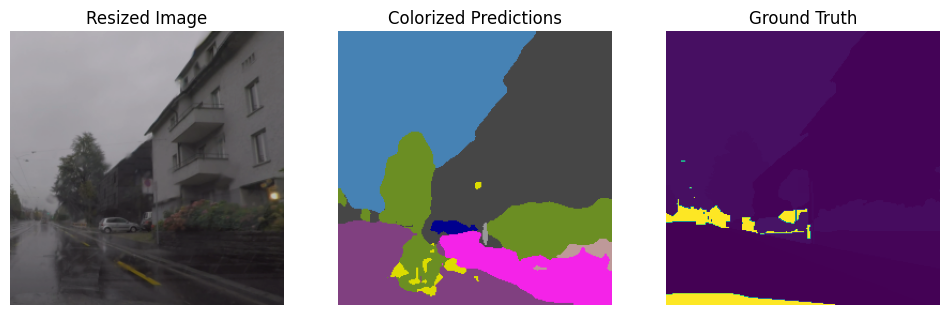

In [301]:
input_tensor, lbl_tensor = dataset[54]

#input_tensor, lbl_tensor = transform(img, label) # To tensor of NCHW
input_tensor = input_tensor.unsqueeze(0).to('cuda')
print(input_tensor.shape, lbl_tensor.shape)
# input_tensor = input_tensor.to('cuda')
# input_tensor.requires_grad = True

# #with torch.no_grad():
output = model(input_tensor)
pred = output.max(1)[1].cpu().numpy()[0] 

colorized_preds = decode_fn(pred).astype('uint8')
colorized_preds = Image.fromarray(colorized_preds)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
image = input_tensor.detach().cpu().numpy()
# Convert tensors to numpy arrays
image_np = (denorm(image.squeeze(0)) * 255).transpose(1, 2, 0).astype(np.uint8)  # From C x H x W to H x W x C
lbl_tensor = lbl_tensor.numpy()
# Display resized_img
axes[0].imshow(image_np)
axes[0].set_title('Resized Image')
axes[0].axis('off')

# Display colorized_preds
axes[1].imshow(colorized_preds)
axes[1].set_title('Colorized Predictions')
axes[1].axis('off')

# Display colorized_preds
axes[2].imshow(lbl_tensor)
axes[2].set_title('Ground Truth')
axes[2].axis('off')

plt.show()

# inference

In [55]:
model = network.modeling.__dict__[MODEL_NAME](num_classes=NUM_CLASSES, output_stride=OUTPUT_STRIDE)
model.load_state_dict(torch.load('/home/talmacsi/Documents/BME/WeatherConverter/seg_model/outputs/checkpoints/deeplabv3plus_resnet101_epoch_28.pth')['model_state_dict'])

model.to('cuda')
model = model.eval()

decode_fn = ACDCDataset.decode_target
utils.set_bn_momentum(model.backbone, momentum=0.01)

In [127]:
val_dataset = ACDCDataset(
    root_dir=data_root,
    split='train',
    weather=['fog', 'rain'],
    transform=val_transform
)

In [14]:
1080//2, 1920//2

(540, 960)

# Try with super res image

In [56]:
val_transform = ExtCompose([
    ExtResize(size=(1080//2,1920//2), interpolation=Image.BILINEAR, just_label=True),
    ExtCenterCrop(size=(512,512), just_label=True),
    ExtToTensor(),
    ExtNormalize(mean=MEAN, std=STD),
])

val_color_transform = T.Compose([
    T.Resize(size=(1080//2,1920//2), interpolation=Image.BILINEAR),
    T.CenterCrop(size=(512,512))
])

# Load your image
img_path = '/home/talmacsi/Documents/BME/WeatherConverter/Swift-SRGAN/swift-srgan/image_super_resolved.png'
gt_label_ids_path = str(gt_path / 'fog/val/GOPR0476/GOPR0476_frame_000854_gt_labelIds.png')
gt_color_path = str(gt_path / 'fog/val/GOPR0476/GOPR0476_frame_000854_gt_labelColor.png')
img = Image.open(img_path).convert("RGB")
label = Image.open(gt_label_ids_path)
lable_colored = Image.open(gt_color_path)

In [57]:
# Apply transformations
input_tensor, lbl_tensor = val_transform(img, label)      
lbl_colored_img = val_color_transform(lable_colored)  
print(type(input_tensor), type(lbl_tensor), type(lbl_colored_img))
# Prepare tensors for the model
input_tensor = input_tensor.unsqueeze(0).to('cuda')  

print(f"Unique values in label tensor: {torch.unique(lbl_tensor)}")

decoded_label = ACDCDataset.encode_target(lbl_tensor)
decoded_label_tensor = torch.from_numpy(np.array(decoded_label)).unsqueeze(0).long().to('cuda')
print(f"Unique values in label tensor: {torch.unique(decoded_label_tensor)}")

print(f"Input Tensor Shape: {input_tensor.shape}")    
print(f"Label Tensor Shape: {decoded_label_tensor.shape}")      
print(f"Label Image Shape: {lbl_colored_img.size}")      


<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'PIL.Image.Image'>
Unique values in label tensor: tensor([ 0,  7,  8, 11, 12, 17, 20, 21, 22, 23, 26], dtype=torch.uint8)
Unique values in label tensor: tensor([  0,   1,   2,   3,   5,   7,   8,   9,  10,  13, 255],
       device='cuda:0')
Input Tensor Shape: torch.Size([1, 3, 512, 512])
Label Tensor Shape: torch.Size([1, 512, 512])
Label Image Shape: (512, 512)


In [58]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

model.eval()

# Zero gradients
model.zero_grad()
if input_tensor.grad is not None:
    input_tensor.grad.zero_()

# Enable gradient tracking on the input tensor
input_tensor.requires_grad = True

print(f"Input Tensor requires gradient: {input_tensor.requires_grad}")
print(f"Input tensor gradient: {input_tensor.grad}")


# Perform inference
output = model(input_tensor)                # Output shape: [1, num_classes, 512, 512]
print(f"Output tensor shape: {output.shape}")
pred = output.argmax(dim=1).squeeze(0).cpu().numpy()  # Shape: [512, 512]

print(f"Predicted tensor shape: {pred.shape}")

loss = criterion(output, decoded_label_tensor.squeeze(1))

loss.backward()

input_gradients = input_tensor.grad  # Shape: [1, 3, 512, 512]

Input Tensor requires gradient: True
Input tensor gradient: None
Output tensor shape: torch.Size([1, 19, 512, 512])
Predicted tensor shape: (512, 512)


In [59]:
def compute_gradient_magnitude(input_gradients, denormalize=True, norm=False):
    gradients_np = input_gradients.detach().cpu().squeeze(0).numpy()  # Shape: [3, 512, 512]

    if denormalize:
        gradients_np = gradients_np * np.array(STD)[:, None, None]
    gradient_magnitude = np.sqrt(np.sum(gradients_np ** 2, axis=0))  # Shape: [512, 512]

    print("Gradient min:", gradient_magnitude.min())
    print("Gradient max:", gradient_magnitude.max())

    if norm:
        # Normalize gradient magnitude to [0,1] for better visualization
        gradient_magnitude = (gradient_magnitude - gradient_magnitude.min()) / (gradient_magnitude.max() - gradient_magnitude.min())

    return gradient_magnitude


gradient_magnitude = compute_gradient_magnitude(input_gradients)

Gradient min: 1.1797244711623163e-06
Gradient max: 0.006410317788340844


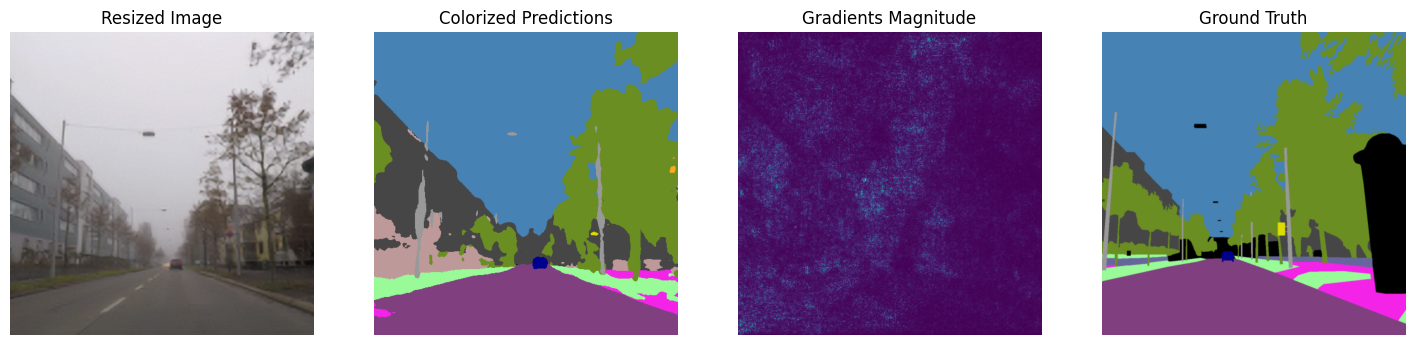

In [60]:
colorized_preds = decode_fn(pred).astype('uint8')
colorized_preds = Image.fromarray(colorized_preds)

# Convert input tensor to numpy array for visualization
image_np = denorm(input_tensor.squeeze(0).detach().cpu()).numpy()
#image_np = input_tensor.squeeze(0).detach().cpu().numpy()
image_np = np.transpose(image_np, (1, 2, 0))  # From [C, H, W] to [H, W, C]
image_np = np.clip(image_np, 0, 1) * 255
image_np = image_np.astype(np.uint8)

# Plotting the input image, predictions, and ground truth
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

# Display input image
axes[0].imshow(image_np)
axes[0].set_title('Resized Image')
axes[0].axis('off')

# Display colorized predictions
axes[1].imshow(colorized_preds)
axes[1].set_title('Colorized Predictions')
axes[1].axis('off')

# Display gradients
axes[2].imshow(gradient_magnitude, cmap='viridis')
axes[2].set_title('Gradients Magnitude')
axes[2].axis('off')

# Display ground truth labels
axes[3].imshow(lbl_colored_img)
axes[3].set_title('Ground Truth')
axes[3].axis('off')

plt.show()

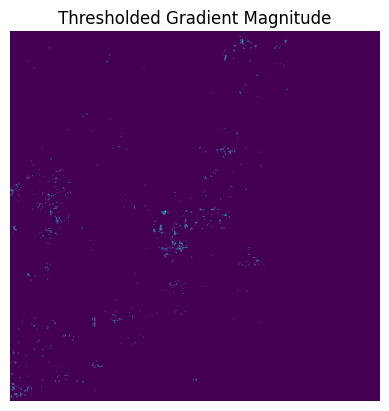

In [66]:
threshold = 0.3 * gradient_magnitude.max()  # Set a threshold, e.g., 10% of max gradient
thresholded_gradient = np.where(gradient_magnitude > threshold, gradient_magnitude, 0)

plt.imshow(thresholded_gradient, cmap='viridis')
plt.title("Thresholded Gradient Magnitude")
plt.axis('off')
plt.show()

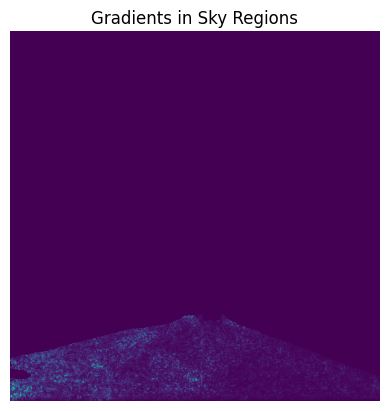

In [64]:
sky_class_id = 0  # Assuming '0' is the ID for the sky class
sky_mask = (pred == sky_class_id).astype(float)
sky_gradients = gradient_magnitude * sky_mask  # Mask gradients outside the sky area

plt.imshow(sky_gradients, cmap='viridis')
plt.title("Gradients in Sky Regions")
plt.axis('off')
plt.show()

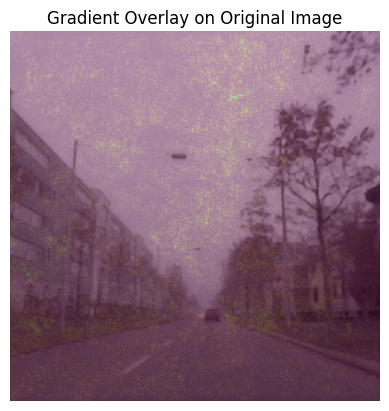

In [63]:
import cv2
import matplotlib.pyplot as plt

gradient_overlay = cv2.addWeighted(image_np, 0.6, cv2.applyColorMap((gradient_magnitude_norm * 255).astype(np.uint8), cv2.COLORMAP_VIRIDIS), 0.4, 0)

plt.imshow(gradient_overlay)
plt.title("Gradient Overlay on Original Image")
plt.axis('off')
plt.show()


# Map gradients back

Gradients 128 shape: torch.Size([1, 3, 128, 128])
Gradient min: 1.8416359299659107e-06
Gradient max: 0.002248741884662657


(-0.5, 127.5, 127.5, -0.5)

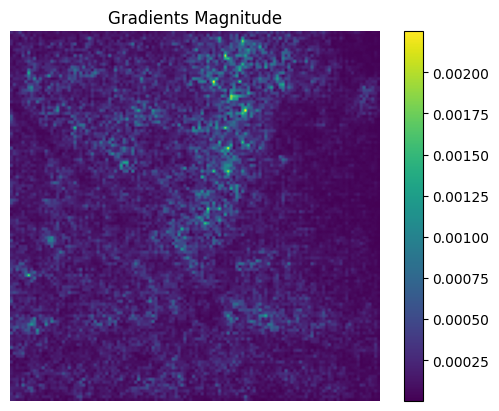

In [53]:
# Avg pool
# Adventages: Smooths out noise, focusing on the overall trend of gradients.
# Disadvantages: Loss of fine details, may not be useful for small objects.

import torch.nn.functional as F

# gradients is a tensor of shape [1, C, 512, 512]
gradients_avg_128 = F.avg_pool2d(input_gradients, kernel_size=4, stride=4)

print(f"Gradients 128 shape: {gradients_avg_128.shape}")

gradient_magnitude_avg_128 = compute_gradient_magnitude(gradients_avg_128, denormalize=True, norm=False)

# Display gradients
plt.imshow(gradient_magnitude_avg_128, cmap='viridis')
plt.title('Gradients Magnitude')
plt.colorbar()
plt.axis('off')

Gradients 128 shape: torch.Size([1, 3, 128, 128])
Gradient min: 1.6102186494201297e-05
Gradient max: 0.005211230747954253


(-0.5, 127.5, 127.5, -0.5)

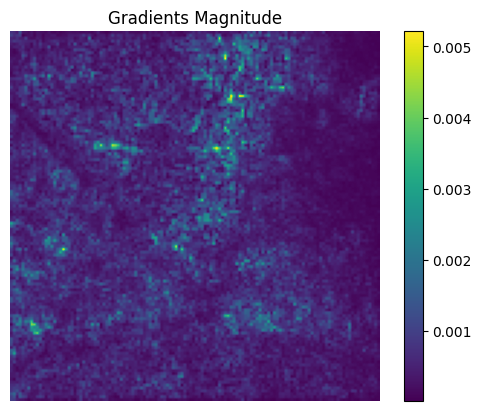

In [51]:
# Max Pool
# Adventages: Preserves fine details, useful for small objects. (Preserves the strongest gradient signals.)
# Disadvantages: May ignore subtle but important gradients.Could introduce bias towards areas with larger gradients (like sky).


# gradients is a tensor of shape [1, C, 512, 512]
gradients_max_128 = F.max_pool2d(input_gradients, kernel_size=4, stride=4)

print(f"Gradients 128 shape: {gradients_max_128.shape}")

gradient_magnitude_max_128 = compute_gradient_magnitude(gradients_max_128, denormalize=True, norm=False)

# Display gradients
plt.imshow(gradient_magnitude_max_128, cmap='viridis')
plt.title('Gradients Magnitude')
plt.colorbar()
plt.axis('off')

Gradients 128 shape: torch.Size([1, 3, 128, 128])
Gradient min: 1.8927286907776919e-06
Gradient max: 0.0036402333384522013


(-0.5, 127.5, 127.5, -0.5)

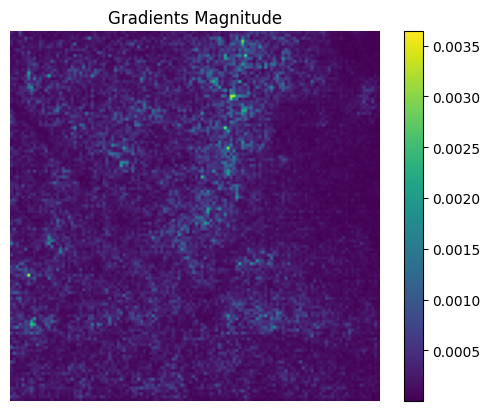

In [52]:
# Interpolation
# Adventages: Preserves spatial continuity and smoothness in gradients.
# Disadvantages: May blur sharp gradient changes. (May introduce artifacts in the gradients.)

gradients_inter_128 = F.interpolate(input_gradients, size=(128, 128), mode='bilinear', align_corners=False)

print(f"Gradients 128 shape: {gradients_inter_128.shape}")

gradient_magnitude_inter_128 = compute_gradient_magnitude(gradients_inter_128, denormalize=True, norm=False)

# Display gradients
plt.imshow(gradient_magnitude_inter_128, cmap='viridis')
plt.title('Gradients Magnitude')
plt.colorbar()
plt.axis('off')

In [54]:
# Average gradients
avg_gradients_min = gradients_avg_128.min().item()
avg_gradients_max = gradients_avg_128.max().item()
print("Average Gradients:")
print("Minimum Value:", avg_gradients_min)
print("Maximum Value:", avg_gradients_max)

# Maximum gradients
max_gradients_min = gradients_max_128.min().item()
max_gradients_max = gradients_max_128.max().item()
print("Maximum Gradients:")
print("Minimum Value:", max_gradients_min)
print("Maximum Value:", max_gradients_max)

# Interpolated gradients
inter_gradients_min = gradients_inter_128.min().item()
inter_gradients_max = gradients_inter_128.max().item()
print("Interpolated Gradients:")
print("Minimum Value:", inter_gradients_min)
print("Maximum Value:", inter_gradients_max)


Average Gradients:
Minimum Value: -0.008172084577381611
Maximum Value: 0.007524947635829449
Maximum Gradients:
Minimum Value: -0.004175786394625902
Maximum Value: 0.018486538901925087
Interpolated Gradients:
Minimum Value: -0.012184148654341698
Maximum Value: 0.011584654450416565
